<a href="https://colab.research.google.com/github/lucasangio01/amazon-books/blob/master/AMD_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!apt-get install openjdk-11-jdk -y
!pip install  --quiet pandas numpy pyspark spark-nlp kaggle

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,367 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import requests
import os
from google.colab import files
import zipfile

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, from_unixtime, length, year, col, array_size, udf, avg, collect_list, row_number, expr, collect_list, concat_ws
from pyspark.sql.types import ArrayType, FloatType, StructType, StructField, IntegerType, StringType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, BucketedRandomProjectionLSH, Normalizer, MinHashLSH
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, StopWordsCleaner, LemmatizerModel, SentenceDetectorDLModel, NorvigSweetingModel, BertSentenceEmbeddings

In [3]:
if not os.path.exists("/content/amazon-books-reviews.zip"):

  uploaded = files.upload()   # upload Kaggle API key (kaggle.json)

  !rm -r ~/.kaggle   # remove any existing Kaggle configuration folder
  !mkdir ~/.kaggle   # create a new Kaggle configuration folder
  !mv ./kaggle.json ~/.kaggle/   # move uploaded Kaggle API key to the correct folder
  !chmod 600 ~/.kaggle/kaggle.json   # set correct permissions for security

  !kaggle datasets download -d mohamedbakhet/amazon-books-reviews   # download dataset from Kaggle

  print("\nFiles downloaded!\nUnzipping the csv files...")

  zip_ref = zipfile.ZipFile('amazon-books-reviews.zip', 'r')
  zip_ref.extractall('/content')   # extract all contents to /content directory
  zip_ref.close()

  print("\nDatasets unzipped and ready to use!")

else:
  print("The datasets have already been downloaded, and are in the directory.")

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.06G/1.06G [00:08<00:00, 298MB/s]
100% 1.06G/1.06G [00:08<00:00, 131MB/s]

Files downloaded!
Unzipping the csv files...

Datasets unzipped and ready to use!




---


# Load data

In [5]:
# some books have duplicates, with some differences in the title. We only keep one of each

def load_duplicated_titles(file_path="https://raw.githubusercontent.com/lucasangio01/amazon-books/master/data/duplicated_titles.txt"):

    response = requests.get(file_path) # send an HTTP GET request to the given file path
    response.raise_for_status() # raise an error if the request was unsuccessful
    return [line.strip() for line in response.text.splitlines() if line.strip()] # split the content by lines, remove whitespace, and exclude empty lines

In [6]:
def load_data(spark, chosen_data):

  duplicated_titles = load_duplicated_titles()   # load list of duplicated titles to filter them out later
  duplicated_df = spark.createDataFrame([(title,) for title in duplicated_titles], ["book_title"])   # create a Spark dataframe of duplicated titles

  reviews_schema = StructType([
      StructField("Id", IntegerType(), True),
      StructField("Title", StringType(), True),
      StructField("Price", IntegerType(), True),
      StructField("User_id", StringType(), True),
      StructField("profileName", StringType(), True),
      StructField("review/helpfulness", StringType(), True),
      StructField("review/score", FloatType(), True),
      StructField("review/time", IntegerType(), True),
      StructField("review/summary", StringType(), True),
      StructField("review/text", StringType(), True)
      ])

  books_data_schema = StructType([
    StructField("Title", StringType(), True),
    StructField("description", StringType(), True),
    StructField("categories", StringType(), True)
    ])

  original_df = (spark.read.csv("../content/Books_rating.csv", header = True, schema = reviews_schema)   # load reviews dataset with defined schema
      .drop("Price", "profileName", "review/summary")
      .filter(length("review/text").between(300, 600))   # only keeping reviews between 300 and 600 characters
      .dropna()
      .withColumn("review_year", year(from_unixtime("review/time")))
      .drop("review/time")
      .withColumn("review/score", col("review/score").cast(IntegerType()))
      .withColumnRenamed("Id", "book_id")
      .withColumnRenamed("Title", "book_title")
      .withColumnRenamed("User_id", "user_id")
      .withColumnRenamed("review/helpfulness", "review_helpfulness")
      .withColumnRenamed("review/score", "review_score")
      .withColumnRenamed("review/text", "review_text")
      .cache()   # cache dataset in memory for faster operations
      )

  reviews_per_book = 50   # maximum number of reviews to keep per book

  if chosen_data == "big_only_fiction":   # choose if you want to analyze only the "fiction" books
    min_reviews = 50
  elif chosen_data == "small_full":   # choose if you want to analyze a smaller subset of the data, for faster results
    min_reviews = 260

  famous_titles = original_df.select("book_title").groupBy("book_title").count().filter(col("count") > min_reviews).drop("count")    # select the books with a certain number of reviews
  df_reviews = original_df.select("book_title", "review_text").join(famous_titles, on="book_title", how="inner").join(duplicated_df, on="book_title", how="left_anti")
  original_df.unpersist()   # free memory from cached original_df

  """
  Bigger dataset: only fiction (6750 x 135)
  Small dataset: full(800 x 16)
  """

  if chosen_data == "big_only_fiction":
    titles_list = df_reviews.select("book_title").distinct()
    books_data_full = spark.read.csv("../content/books_data.csv", inferSchema = True, header = True).select("Title", "categories", "description").withColumnRenamed("Title", "book_title").dropna().filter(col("categories") == "['Fiction']").join(titles_list, on="book_title", how="inner").cache()
    books_with_description = books_data_full.select("book_title", "description").cache()

  window_spec = Window.partitionBy("book_title").orderBy("review_text")   # window spec: partition by book, order reviews by text
  df_reviews = df_reviews.withColumn("row_num", row_number().over(window_spec)).filter(col("row_num") <= reviews_per_book)   # assign row number to each review, then select how many reviews to use for the analysis for each book

  if chosen_data == "big_only_fiction":
    df_reviews = df_reviews.drop("row_num", "description").join(books_data_full, on = "book_title", how = "inner").cache()
    df_descriptions = books_data_full.select("book_title", "description").cache()
    return df_reviews, df_descriptions
  else:
    df_reviews = df_reviews.drop("row_num").cache()
    return df_reviews, None


# Core functions

In [21]:
def pretrained_pipeline(dataset):

  if dataset == df_reviews:
    text_column = "review_text"
  elif dataset == df_descriptions:
    text_column = "description"

  document_assembler = DocumentAssembler().setInputCol(text_column).setOutputCol("document")   # convert raw text into Spark NLP Document format
  sentence_embeddings = BertSentenceEmbeddings().pretrained("sent_small_bert_L2_128", "en").setInputCols(["document"]).setOutputCol("embeddings")   # load a pretrained BERT model and generate sentence embeddings
  pipeline = Pipeline(stages = [document_assembler, sentence_embeddings])   # create an NLP pipeline with document assembler and embeddings

  result = pipeline.fit(dataset).transform(dataset)   # run the pipeline on the dataset to generate embeddings
  extract_embedding = udf(lambda arr: arr[0].embeddings, ArrayType(FloatType()))   # UDF to extract embedding vector from the embeddings column
  result = result.withColumn("embedding_vector", extract_embedding("embeddings")).select("book_title", "embedding_vector")   # add a column with extracted embedding vectors

  to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())   # UDF to convert embedding list into a dense Spark ML vector
  result = result.withColumn("embedding_vector_ml", to_vector_udf("embedding_vector")).select("book_title", "embedding_vector_ml")   # add ML-compatible vector column

  return result

In [19]:
def custom_pipeline(dataset):

  if dataset == customized_reviews_grouped:
    text_column = "review_text"
  elif dataset == customized_descriptions_grouped:
    text_column = "description"

  document_assembler = DocumentAssembler().setInputCol(text_column).setOutputCol("document")   # convert raw text into Spark NLP Document format
  tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")   # split text into individual tokens
  stopwords_cleaner = StopWordsCleaner().setInputCols(["token"]).setOutputCol("clean_tokens").setCaseSensitive(False)   # remove common stopwords
  lemmatizer = LemmatizerModel.pretrained().setInputCols(["clean_tokens"]).setOutputCol("lemma")   # lemmatize tokens (reduce to base form)
  finisher = Finisher().setInputCols(["lemma"]).setCleanAnnotations(True)   # convert Spark NLP annotations back to plain text tokens

  pipeline = Pipeline(stages = [document_assembler, tokenizer, stopwords_cleaner, lemmatizer, finisher])   # define full NLP preprocessing pipeline
  result = pipeline.fit(dataset).transform(dataset).select("book_title", "finished_lemma") # apply pipeline and keep book title + lemmatized tokens

  return result

In [9]:
def average_vectors(vectors):

    arrays = np.array([v.toArray() for v in vectors])   # convert Spark MLlib vectors to NumPy arrays
    avg_arr = np.mean(arrays, axis=0)   # compute element-wise average across all vectors

    return DenseVector(avg_arr)   # return the average as a DenseVector (Spark MLlib format)


def group_vectors(embedded_data):

  avg_udf = udf(average_vectors, VectorUDT())   # define UDF to average vectors in each group
  book_embeddings = embedded_data.groupBy("book_title").agg(collect_list("embedding_vector_ml").alias("embeddings_list")).withColumn("book_embedding", avg_udf("embeddings_list")).select("book_title", "book_embedding")

  normalizer = Normalizer(inputCol = "book_embedding", outputCol = "norm_embedding", p = 2.0)   # L2-normalize embeddings
  book_embeddings = normalizer.transform(book_embeddings).select("book_title", "norm_embedding")   # add normalized embeddings

  return book_embeddings


def group_text(dataset):

  if dataset == df_reviews:
    text_column = "review_text"
  else:
    text_column = "description"

  return (dataset.groupBy("book_title").agg(concat_ws(" ", collect_list(text_column)).alias(text_column)))   # concatenate all texts for each book into one string

In [10]:
def compute_cosine_similarity(grouped_reviews):

  lsh = BucketedRandomProjectionLSH(inputCol = "norm_embedding", outputCol = "hashes", bucketLength = 2.0, numHashTables = 3)   # LSH model for cosine similarity using normalized embeddings
  cosine_similarity_model = lsh.fit(grouped_reviews)
  similar_books_cosine = cosine_similarity_model.approxSimilarityJoin(grouped_reviews, grouped_reviews, threshold = 0.4, distCol = "distance").filter("datasetA.book_title < datasetB.book_title").withColumn("cosine_similarity", (1 - col("distance"))).selectExpr("datasetA.book_title as book1", "datasetB.book_title as book2", "cosine_similarity").orderBy("cosine_similarity", ascending = False)

  return similar_books_cosine


def compute_jaccard_similarity(grouped_reviews):

  hashingTF = HashingTF(inputCol = "finished_lemma", outputCol = "features", numFeatures = 10000)   # convert tokens to feature vectors using hashing trick
  featurized = hashingTF.transform(grouped_reviews)
  mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 3)   # LSH model for Jaccard similarity

  jaccard_similarity_model = mh.fit(featurized)
  similar_books_jaccard = jaccard_similarity_model.approxSimilarityJoin(featurized, featurized, threshold = 0.9, distCol="jaccard_distance").filter("datasetA.book_title < datasetB.book_title").withColumn("jaccard_similarity", 1 - col("jaccard_distance")).selectExpr("datasetA.book_title as book1", "datasetB.book_title as book2", "jaccard_similarity").orderBy("jaccard_similarity", ascending = False)

  return similar_books_jaccard



---

# Notebook:

## Choose data

In [11]:
spark = (SparkSession.builder.appName("Books").config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.3.3").getOrCreate())

In [12]:
"""
Bigger dataset: big_only_fiction (6750 x 135)
Small dataset: small_full (800 x 16)
"""

chosen_data = "big_only_fiction"
df_reviews, df_descriptions = load_data(spark, chosen_data)

In [13]:
"""
books_number = df_reviews.groupBy("book_title").count()
reviews_number = df_reviews.count()
print(f"Number of rows (reviews): {reviews_number}\nNumber of books: {books_number.count()}")
"""

'\nbooks_number = df_reviews.groupBy("book_title").count()\nreviews_number = df_reviews.count()\nprint(f"Number of rows (reviews): {reviews_number}\nNumber of books: {books_number.count()}")\n'

In [14]:
"""books_number.sort("book_title", ascending = True).show(150, truncate = False)"""

'books_number.sort("book_title", ascending = True).show(150, truncate = False)'

## Check Jaccard similarity of the books




In [17]:
customized_reviews_grouped = group_text(df_reviews)   # group all reviews by book title into one concatenated text per book
customized_reviews = custom_pipeline(customized_reviews_grouped)   # preprocess text (tokenization, stopword removal, lemmatization)
similar_reviews_jaccard = compute_jaccard_similarity(customized_reviews).cache()   # compute Jaccard similarity between books and cache results

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [18]:
#similar_reviews_jaccard.show(10)

In [27]:
customized_descriptions_grouped = group_text(df_descriptions)
customized_descriptions = custom_pipeline(customized_descriptions_grouped)
similar_descriptions_jaccard = compute_jaccard_similarity(customized_descriptions).cache()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
similar_descriptions_jaccard.show(10)

+--------------------+--------------------+-------------------+
|               book1|               book2| jaccard_similarity|
+--------------------+--------------------+-------------------+
|City of Night (De...|Prodigal Son (Dea...| 0.5789473684210527|
|      House of Mirth|Sense and Sensibi...|0.28301886792452824|
|Memory in Death (...|True Believer (La...|0.12269938650306744|
|Dreamcatcher Movi...|       Wish You Well|0.11895910780669139|
|Dreamcatcher Movi...|        Little Women|0.11811023622047245|
|Bridget Jones's D...| Pride and Prejudice|0.11764705882352944|
|        Little Women|       Wish You Well|0.11267605633802813|
|      Case Histories|     The Good German|0.10227272727272729|
+--------------------+--------------------+-------------------+



## Check cosine similarity of the books



In [23]:
embedded_reviews = pretrained_pipeline(df_reviews)   # generate BERT embeddings for each review
embedded_reviews_grouped = group_vectors(embedded_reviews)   # average + normalize embeddings per book
similar_reviews_cosine = compute_cosine_similarity(embedded_reviews_grouped).cache()   # compute cosine similarity between books and cache results

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


7 minutes

In [ ]:
#similar_reviews_cosine.show(10, truncate = True)

In [22]:
embedded_descriptions = pretrained_pipeline(df_descriptions)
embedded_descriptions_grouped = group_vectors(embedded_descriptions)
similar_descriptions_cosine = compute_cosine_similarity(embedded_descriptions_grouped).cache()

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


4 minutes

In [ ]:
#similar_descriptions_cosine.show(10, truncate = True)

In [24]:
chosen_book = "Hannibal"

books_list_rev = similar_reviews_cosine.filter(col("book1") == chosen_book)

if books_list_rev.isEmpty():
  print("Couldn't find the book. Try another one!")
else:
  print(f"Top 3 most similar books to {chosen_book}, according to user reviews (cosine similarity):\n")
  books_list_rev.show(3, truncate = False)

if books_list_rev.count() < 3:
  print("\nLess than 3 books are showing, since the similarity with other books is too low.")

Top 3 most similar books to Hannibal, according to user reviews (cosine similarity):

+--------+-------------------------------------------------------+------------------+
|book1   |book2                                                  |cosine_similarity |
+--------+-------------------------------------------------------+------------------+
|Hannibal|The Last Templar                                       |0.8848990714912056|
|Hannibal|The Sunday Philosophy Club (Isabel Dalhousie Mysteries)|0.8848443217594665|
|Hannibal|Naked Empire (Sword of Truth, Book 8)                  |0.8822976760114922|
+--------+-------------------------------------------------------+------------------+
only showing top 3 rows



In [25]:
chosen_book = "Moon Tiger"

books_list_descr = similar_descriptions_cosine.filter(col("book1") == chosen_book)

if books_list_descr.isEmpty():
  print("Couldn't find the book. Try another one!")
else:
  print(f"Top 3 most similar books to {chosen_book}, according to book description (cosine similarity):\n")
  books_list_descr.show(3, truncate = False)

  if books_list_descr.count() < 3:
    print("\nLess than 3 books are showing, since the similarity with other books is too low.")

Top 3 most similar books to Moon Tiger, according to book description (cosine similarity):

+----------+----------------+------------------+
|book1     |book2           |cosine_similarity |
+----------+----------------+------------------+
|Moon Tiger|The Pearl       |0.7189800640535702|
|Moon Tiger|Whitney, My Love|0.6969640680856999|
|Moon Tiger|The Reader      |0.689377755480393 |
+----------+----------------+------------------+
only showing top 3 rows



In [26]:
first_book = "Little Women"
second_book = "Plainsong"

books_rev_1on1 = similar_reviews_cosine.filter((col("book1") == first_book) & (col("book2") == second_book))

if books_rev_1on1.isEmpty():
  print("Couldn't find the books. Try other ones!")
else:
  print(f"Cosine similarity between {first_book} and {second_book}, based on user reviews:\n")
  books_rev_1on1.show(truncate = False)

Cosine similarity between Little Women and Plainsong, based on user reviews:

+------------+---------+------------------+
|book1       |book2    |cosine_similarity |
+------------+---------+------------------+
|Little Women|Plainsong|0.8363001585670673|
+------------+---------+------------------+



## Comparing Jaccard and Cosine

In [28]:
reviews_merged = similar_reviews_cosine.join(similar_reviews_jaccard, on = ["book1", "book2"], how = "inner")

print("\n" + "-" * 100)
print(f"\nSHOWING SIMILAR BOOKS BASED ON USERS REVIEWS - COSINE SIMILARITY VS JACCARD SIMILARITY\nChosen dataset: {chosen_data}\n")

reviews_merged.show(5, truncate = False)


----------------------------------------------------------------------------------------------------

SHOWING SIMILAR BOOKS BASED ON USERS REVIEWS - COSINE SIMILARITY VS JACCARD SIMILARITY
Chosen dataset: big_only_fiction

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+------------------+-------------------+
|book1                                                                           |book2                                                                                 |cosine_similarity |jaccard_similarity |
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+------------------+-------------------+
|The Plains of Passage (Earth's Children (Prebound))                             |The Valley of Horses (Earth's Children Series)                     

In [29]:
descriptions_merged = similar_descriptions_cosine.join(similar_descriptions_jaccard, on = ["book1", "book2"], how = "inner")

print("\n" + "-" * 100)
print(f"\nSHOWING SIMILAR BOOKS BASED ON BOOK DESCRIPTION - COSINE SIMILARITY VS JACCARD SIMILARITY\nChosen dataset: {chosen_data}\n")

descriptions_merged.show(5, truncate = False)


----------------------------------------------------------------------------------------------------

SHOWING SIMILAR BOOKS BASED ON BOOK DESCRIPTION - COSINE SIMILARITY VS JACCARD SIMILARITY
Chosen dataset: big_only_fiction

+--------------------------------------------------+-------------------------------------------------+------------------+-------------------+
|book1                                             |book2                                            |cosine_similarity |jaccard_similarity |
+--------------------------------------------------+-------------------------------------------------+------------------+-------------------+
|City of Night (Dean Koontz's Frankenstein, Book 2)|Prodigal Son (Dean Koontz's Frankenstein, Book 1)|0.6263081692756656|0.5789473684210527 |
|House of Mirth                                    |The Pearl                                        |0.6581280032237573|0.2911392405063291 |
|House of Mirth                                    |Sense and S

## Visualizations

In [30]:
embedded_reviews_grouped_pd = embedded_reviews_grouped.toPandas()

norm_embeddings = np.vstack(embedded_reviews_grouped_pd["norm_embedding"].values)   # stack embeddings into a 2D NumPy array
norm_embeddings = StandardScaler().fit_transform(norm_embeddings)   # standardize embeddings (zero mean, unit variance)

book_titles = embedded_reviews_grouped_pd["book_title"].values   # extract book titles as NumPy array

In [31]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)   # initialize UMAP model for dimensionality reduction to 2D
norm_embeddings_2d = umap_model.fit_transform(norm_embeddings)   # fit UMAP on standardized embeddings and transform to 2D coordinates

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


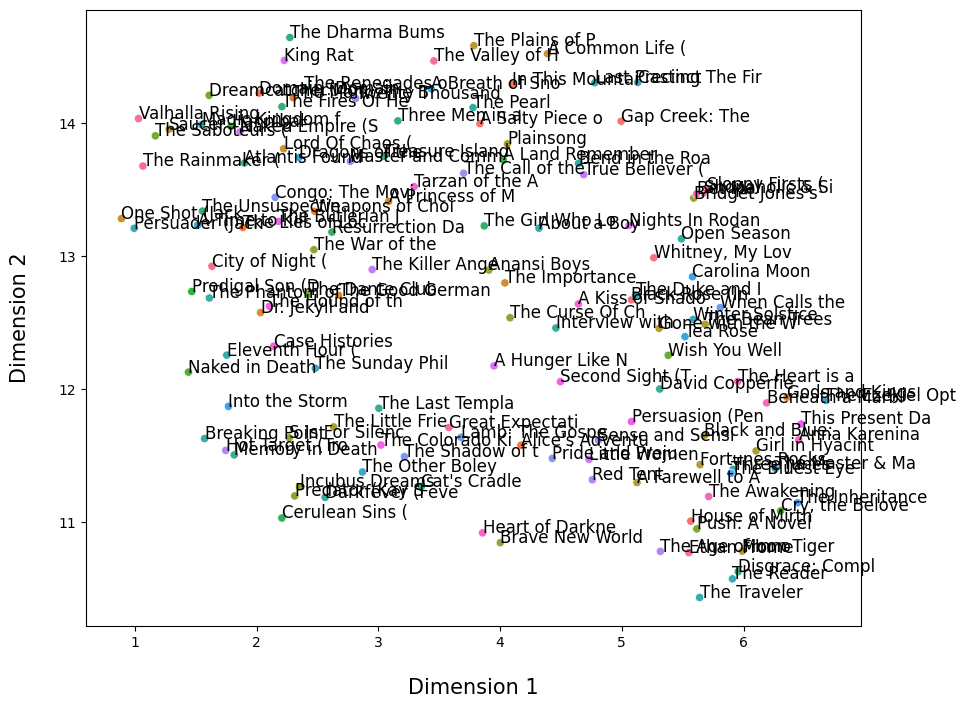

In [32]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = norm_embeddings_2d[:, 0], y = norm_embeddings_2d[:, 1], hue = book_titles, legend = False)

for i, label in enumerate(book_titles):
    plt.text(norm_embeddings_2d[i, 0], norm_embeddings_2d[i, 1], label[:15], fontsize=12)

#plt.title("2D visualization of book embeddings\n")
plt.xlabel("\nDimension 1", fontsize = 15)
plt.ylabel("Dimension 2\n", fontsize = 15)
plt.show()

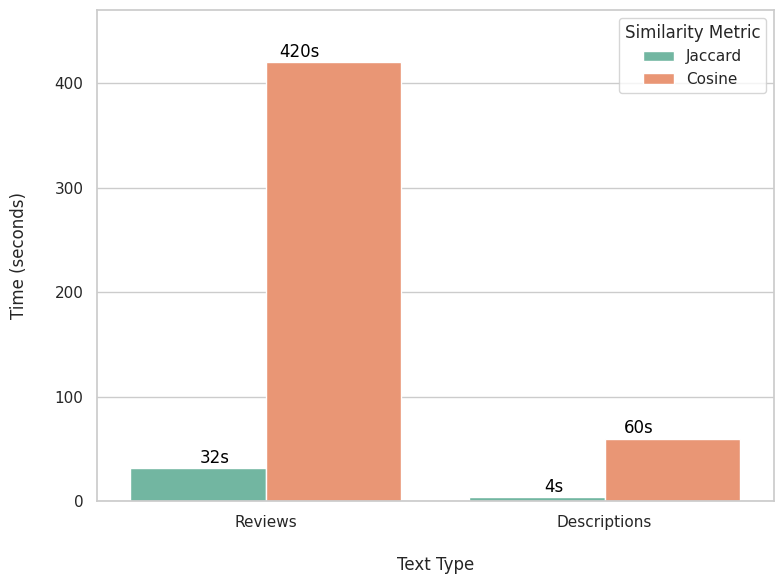

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style="whitegrid")

# Data
data = {
    "Category": ["Reviews", "Reviews", "Descriptions", "Descriptions"],
    "Similarity": ["Jaccard", "Cosine", "Jaccard", "Cosine"],
    "Time (s)": [32, 420, 4, 60]
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Category", y="Time (s)", hue="Similarity", palette="Set2")

# Add annotations
for i, row in df.iterrows():
    plt.text(i // 2 + (-0.15 if row["Similarity"] == "Jaccard" else 0.1),
             row["Time (s)"] + 5,
             f'{row["Time (s)"]}s',
             color='black', ha='center')

plt.ylabel("Time (seconds)\n")
plt.xlabel("\nText Type")
plt.ylim(0, max(df["Time (s)"]) + 50)
plt.legend(title="Similarity Metric")
plt.tight_layout()
plt.show()
